[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/jkanclerz/data-science-workshop-2021/blob/main/90--trains/11--data-exploration.ipynb)





In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz -O spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q pyspark findspark

In [85]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .master("local") \
    .appName("Test it 2") \
    .getOrCreate()
sc = spark.sparkContext

In [86]:
from pyspark.sql import types

In [87]:
types.StructType?

In [88]:
from pyspark.sql import types
from pyspark.sql.types import StructType, LongType, StructField, TimestampType

In [89]:
StructField?

In [90]:
from pyspark.sql import types
from pyspark.sql.types import StructType, LongType, StructField, TimestampType, StringType

# root
#  |-- train_id: long (nullable = true)
#  |-- train_name: string (nullable = true)
#  |-- schedule_date: timestamp (nullable = true)
#  |-- schedule_id: long (nullable = true)
#  |-- arrival_delay: long (nullable = true)
#  |-- arrival_time: timestamp (nullable = true)
#  |-- departure_delay: long (nullable = true)
#  |-- departure_time: timestamp (nullable = true)
#  |-- station_name: string (nullable = true)

schema = StructType([
        StructField('train_id', LongType(), nullable=False),
        StructField('train_name', StringType(), nullable=False),
        StructField('schedule_date', TimestampType(), nullable=False),
        StructField('schedule_id', LongType(), nullable=False),
        StructField('arrival_delay', LongType()),
        StructField('arrival_time', TimestampType()),
        StructField('departure_delay', LongType()),
        StructField('departure_time', TimestampType()),
        StructField('station_name', StringType(), nullable=False)
])
    
trains = spark.read.format("csv")\
        .schema(schema)\
        .load("trains_sample.csv")

In [91]:
trains.printSchema()

root
 |-- train_id: long (nullable = true)
 |-- train_name: string (nullable = true)
 |-- schedule_date: timestamp (nullable = true)
 |-- schedule_id: long (nullable = true)
 |-- arrival_delay: long (nullable = true)
 |-- arrival_time: timestamp (nullable = true)
 |-- departure_delay: long (nullable = true)
 |-- departure_time: timestamp (nullable = true)
 |-- station_name: string (nullable = true)



In [92]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [93]:
trains.registerTempTable("trains")

In [94]:
sqlContext.sql("""
    Select * from trains LIMIT 5
""").show()

+--------+----------+-------------------+-----------+-------------+-------------------+---------------+-------------------+---------------+
|train_id|train_name|      schedule_date|schedule_id|arrival_delay|       arrival_time|departure_delay|     departure_time|   station_name|
+--------+----------+-------------------+-----------+-------------+-------------------+---------------+-------------------+---------------+
|     261|   32314/5|2018-12-08 00:00:00|   53468349|         null|               null|              0|2018-12-08 14:07:00|  Kraków Główny|
|     261|   32314/5|2018-12-08 00:00:00|   53468349|            0|2018-12-08 14:12:30|              0|2018-12-08 14:13:00|Kraków Batowice|
|     261|   32314/5|2018-12-08 00:00:00|   53468349|            0|2018-12-08 14:20:30|              0|2018-12-08 14:21:00|         Zastów|
|     261|   32314/5|2018-12-08 00:00:00|   53468349|            0|2018-12-08 14:24:18|              0|2018-12-08 14:24:48|      Baranówka|
|     261|   32314/5

## Czy w weekendy pociągi sppózniaja sie bardziej?

In [95]:
import pyspark.sql.functions as F

In [96]:
DELAY_BY_DAY = trains\
    .select(
        F.dayofweek(F.col('arrival_time')).alias('day'),
        F.col('arrival_delay').alias('arrival_delay'),
    )\
    .filter(
        F.col('day').isNotNull()
    )\
    .groupBy(
        F.col('day')
    )\
    .agg(
        F.avg(F.col("arrival_delay")).alias('avg_delay'),
        F.min(F.col("arrival_delay")).alias('min_delay'),
        F.max(F.col("arrival_delay")).alias('max_delay'),
        F.stddev(F.col("arrival_delay")).alias('stddev_delay'),
    ) \
    .sort(
        F.col('day').asc()
    )

In [97]:
DELAY_BY_DAY.show()

+---+------------------+---------+---------+------------------+
|day|         avg_delay|min_delay|max_delay|      stddev_delay|
+---+------------------+---------+---------+------------------+
|  1|1.7518981141317658|       -4|      210|7.3786559668596805|
|  2| 3.023520549091822|       -6|      144| 9.537322557941811|
|  3| 3.335285384361597|       -7|      105| 8.357160022522594|
|  4|  3.40817843866171|       -3|      129| 9.388605748780208|
|  5| 3.659818285994925|       -5|      217|13.736058017098612|
|  6| 2.908450704225352|       -6|       56| 5.772482501678014|
|  7|3.1962864721485413|       -3|      153|10.279880251106581|
+---+------------------+---------+---------+------------------+



In [98]:
plt_data = DELAY_BY_DAY.toPandas()


In [99]:
plt_data

,day,avg_delay,min_delay,max_delay,stddev_delay
0,1,1.751898,-4,210,7.378656
1,2,3.023521,-6,144,9.537323
2,3,3.335285,-7,105,8.357160
3,4,3.408178,-3,129,9.388606
4,5,3.659818,-5,217,13.736058
5,6,2.908451,-6,56,5.772483
6,7,3.196286,-3,153,10.279880


In [100]:
plt_data.plot?

<AxesSubplot:title={'center':'Delay by day'}, xlabel='day'>

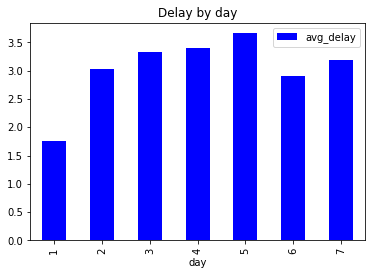

In [101]:
plt_data.plot(kind='bar', x='day', y="avg_delay", title="Delay by day", color="blue")

In [102]:
DELAY_BY_MONTH = trains\
    .select(
        F.month(F.col('arrival_time')).alias('month'),
        F.col('arrival_delay').alias('arrival_delay'),
    )\
    .filter(
        F.col('month').isNotNull()
    )\
    .groupBy(
        F.col('month')
    )\
    .agg(
        F.avg(F.col("arrival_delay")).alias('avg_delay'),
        F.min(F.col("arrival_delay")).alias('min_delay'),
        F.max(F.col("arrival_delay")).alias('max_delay'),
        F.stddev(F.col("arrival_delay")).alias('stddev_delay'),
    ) \
    .sort(
        F.col('month').asc()
    )

In [103]:
DELAY_BY_MONTH.show()

+-----+------------------+---------+---------+------------------+
|month|         avg_delay|min_delay|max_delay|      stddev_delay|
+-----+------------------+---------+---------+------------------+
|    1| 2.291463064098879|       -3|       45| 5.380730969112602|
|    2| 1.711704080192009|       -3|       43|4.5957032676920635|
|    3| 1.886346004654771|       -3|       56|3.9293366888957415|
|    4| 2.066736869817033|       -3|       83| 4.883977258428644|
|    5|2.4783734783734785|       -4|       43| 5.788090622487138|
|    6|2.6023268853378188|       -3|      104| 7.796540061031733|
|    7| 4.658628841607565|       -4|      129|13.937600706046675|
|    8| 4.099151406878071|       -7|      153|14.632443154466882|
|    9| 4.464003387916431|       -4|      217|17.823415051014937|
|   10|3.5203774617067833|       -6|       86| 7.202533063266867|
|   11|4.0176211453744495|       -6|      210|10.190062871321532|
|   12| 3.120684292379471|       -5|       72|  6.33728641424266|
+-----+---

<AxesSubplot:title={'center':'Delay by month'}, xlabel='month'>

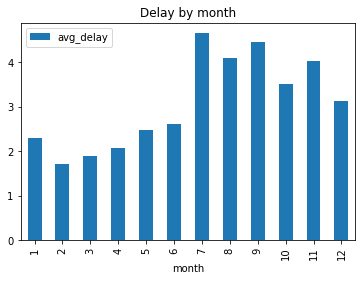

In [104]:
plt_data = DELAY_BY_MONTH.toPandas()
plt_data[['month', 'avg_delay']].plot(kind='bar', x='month', title="Delay by month")

In [132]:
DELAY_BY_DAY_MONTH = trains\
    .select(
        F.to_date(F.date_format('arrival_time','yyyy-MM-dd'), 'yyyy-MM-dd').alias('day'),
        F.col('arrival_delay').alias('arrival_delay'),
    )\
    .filter(
        F.col('day').isNotNull()
    )\
    .groupBy(
        F.col('day').alias('day'),
    )\
    .agg(
        F.avg(F.col("arrival_delay")).alias('avg_delay')
    ) \
    .sort(
        F.col('avg_delay').asc()
    )

In [133]:
DELAY_BY_DAY_MONTH.printSchema()

root
 |-- day: date (nullable = true)
 |-- avg_delay: double (nullable = true)



In [138]:
plt_data = DELAY_BY_DAY_MONTH.toPandas()

In [139]:
plt_data.set_index(['day'], inplace=True)

In [150]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=18,9

In [156]:
plt_data = plt_data.sort_index()

In [162]:
plt_data['rolling'] = plt_data.rolling(15).mean()

<AxesSubplot:xlabel='day'>

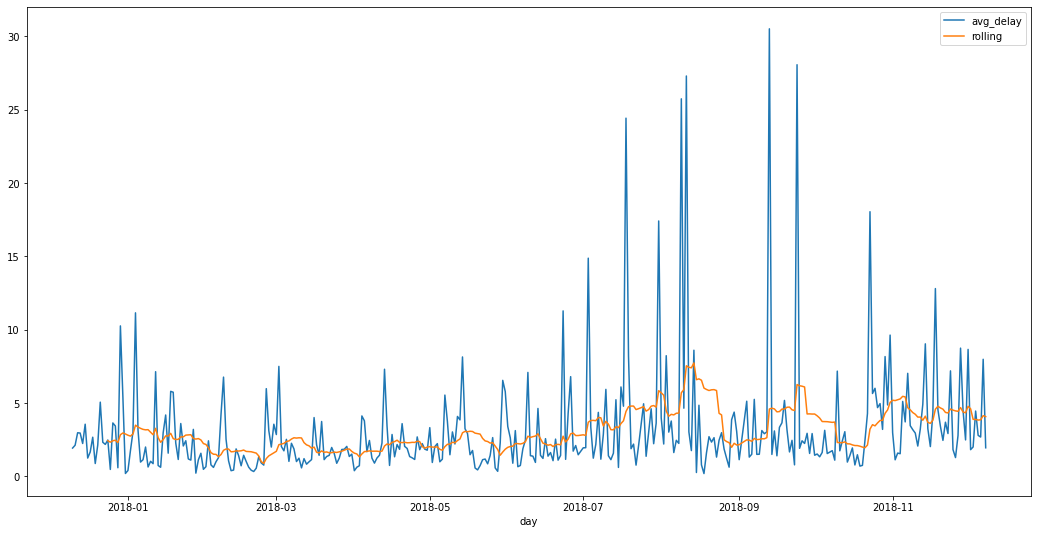

In [163]:
plt_data.plot.line()

## Czy jest jakiś czarny punk stacja??

In [78]:
DELAY_BY_STATION = trains\
    .select(
        col('station_name'),
        col('arrival_delay').alias('avg_delay'),
    )\
    .groupBy(col('station_name'))\
    .avg() \
    .dropna() \
    .sort(col('avg(avg_delay)').asc()) \
    .cache()

In [79]:
DELAY_BY_STATION.createTempView('delay_by_station')

In [82]:
by_stations = sqlContext.sql("""
    Select * from delay_by_station order by `avg(avg_delay)` DESC LIMIT 20
""")

In [83]:
by_stations.toPandas()

,station_name,avg(avg_delay)
0,Kraków Płaszów,58.000000
1,Wrocław Nadodrze,7.120448
2,Wrocław Sołtysowice,6.834734
3,Wrocław Psie Pole,6.773109
4,Borowa Oleśnicka,6.680672
5,Długołęka,6.414566
6,Twardogóra,6.362069
7,Oleśnica Rataje,6.146893
8,Dąbrowa Oleśnicka,6.146067
9,Wrocław Mikołajów,6.022409


In [164]:
sc.stop()